<span style="color:orange; font-weight:bold">Note: To answer questions based on text documents, we recommend the procedure in <a href="https://github.com/openai/openai-cookbook/blob/main/examples/Question_answering_using_embeddings.ipynb">Question Answering using Embeddings</a>. Some of the code below may rely on <a href="https://github.com/openai/openai-cookbook/tree/main/transition_guides_for_deprecated_API_endpoints">deprecated API endpoints</a>.</span>

# 1. Collect Wikipedia data about Olympic Games 2020

The idea of this project is to create a question answering model, based on a few paragraphs of provided text. Base GPT-3 models do a good job at answering questions when the answer is contained within the paragraph, however if the answer isn't contained, the base models tend to try their best to answer anyway, often leading to confabulated answers. 

To create a model which answers questions only if there is sufficient context for doing so, we first create a dataset of questions and answers based on paragraphs of text. In order to train the model to answer only when the answer is present, we also add adversarial examples, where the question doesn't match the context. In those cases, we ask the model to output "No sufficient context for answering the question". 

We will perform this task in three notebooks:
1. The first (this) notebook focuses on collecting recent data, which GPT-3 didn't see during it's pre-training. We picked the topic of Olympic Games 2020 (which actually took place in the summer of 2021), and downloaded 713 unique pages. We organized the dataset by individual sections, which will serve as context for asking and answering the questions.
2. The [second notebook](olympics-2-create-qa.ipynb) will utilize Davinci-instruct to ask a few questions based on a Wikipedia section, as well as answer those questions, based on that section.
3. The [third notebook](olympics-3-train-qa.ipynb) will utilize the dataset of context, question and answer pairs to additionally create adversarial questions and context pairs, where the question was not generated on that context. In those cases the model will be prompted to answer "No sufficient context for answering the question". We will also train a discriminator model, which predicts whether the question can be answered based on the context or not.

## 1.1 Data extraction using the wikipedia API
Extracting the data will take about half an hour, and processing will likely take about as much.

In [1]:
import pandas as pd
import wikipedia


def filter_olympic_2020_titles(titles):
    """
    Get the titles which are related to Olympic games hosted in 2020, given a list of titles
    """
    titles = [title for title in titles if 'nutrition' in title]
    
    return titles

def get_wiki_page(title):
    """
    Get the wikipedia page given a title
    """
    try:
        return wikipedia.page(title)
    except wikipedia.exceptions.DisambiguationError as e:
        return wikipedia.page(e.options[0])
    except wikipedia.exceptions.PageError as e:
        return None

def recursively_find_all_pages(titles, titles_so_far=set()):
    """
    Recursively find all the pages that are linked to the Wikipedia titles in the list
    """
    all_pages = []
    
    titles = list(set(titles) - titles_so_far)
    titles = filter_olympic_2020_titles(titles)
    titles_so_far.update(titles)
    for title in titles:
        page = get_wiki_page(title)
        if page is None:
            continue
        all_pages.append(page)

        new_pages = recursively_find_all_pages(page.links, titles_so_far)
        for pg in new_pages:
            if pg.title not in [p.title for p in all_pages]:
                all_pages.append(pg)
        titles_so_far.update(page.links)
    return all_pages


pages = recursively_find_all_pages(["nutrition"])
len(pages)

36

## 1.2 Filtering the Wikipedia pages and splitting them into sections by headings
We remove sections unlikely to contain textual information, and ensure that each section is not longer than the token limit

In [3]:

import re
from typing import Set
from transformers import GPT2TokenizerFast

import numpy as np
from nltk.tokenize import sent_tokenize

tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def count_tokens(text: str) -> int:
    """count the number of tokens in a string"""
    return len(tokenizer.encode(text))

def reduce_long(
    long_text: str, long_text_tokens: bool = False, max_len: int = 590
) -> str:
    """
    Reduce a long text to a maximum of `max_len` tokens by potentially cutting at a sentence end
    """
    if not long_text_tokens:
        long_text_tokens = count_tokens(long_text)
    if long_text_tokens > max_len:
        sentences = sent_tokenize(long_text.replace("\n", " "))
        ntokens = 0
        for i, sentence in enumerate(sentences):
            ntokens += 1 + count_tokens(sentence)
            if ntokens > max_len:
                return ". ".join(sentences[:i]) + "."

    return long_text

discard_categories = ['See also', 'References', 'External links', 'Further reading', "Footnotes",
    "Bibliography", "Sources", "Citations", "Literature", "Footnotes", "Notes and references",
    "Photo gallery", "Works cited", "Photos", "Gallery", "Notes", "References and sources",
    "References and notes",]


def extract_sections(
    wiki_text: str,
    title: str,
    max_len: int = 1500,
    discard_categories: Set[str] = discard_categories,
) -> str:
    """
    Extract the sections of a Wikipedia page, discarding the references and other low information sections
    """
    if len(wiki_text) == 0:
        return []

    # find all headings and the coresponding contents
    headings = re.findall("==+ .* ==+", wiki_text)
    for heading in headings:
        wiki_text = wiki_text.replace(heading, "==+ !! ==+")
    contents = wiki_text.split("==+ !! ==+")
    contents = [c.strip() for c in contents]
    assert len(headings) == len(contents) - 1

    cont = contents.pop(0).strip()
    outputs = [(title, "Summary", cont, count_tokens(cont)+4)]
    
    # discard the discard categories, accounting for a tree structure
    max_level = 100
    keep_group_level = max_level
    remove_group_level = max_level
    nheadings, ncontents = [], []
    for heading, content in zip(headings, contents):
        plain_heading = " ".join(heading.split(" ")[1:-1])
        num_equals = len(heading.split(" ")[0])
        if num_equals <= keep_group_level:
            keep_group_level = max_level

        if num_equals > remove_group_level:
            if (
                num_equals <= keep_group_level
            ):
                continue
        keep_group_level = max_level
        if plain_heading in discard_categories:
            remove_group_level = num_equals
            keep_group_level = max_level
            continue
        nheadings.append(heading.replace("=", "").strip())
        ncontents.append(content)
        remove_group_level = max_level

    # count the tokens of each section
    ncontent_ntokens = [
        count_tokens(c)
        + 3
        + count_tokens(" ".join(h.split(" ")[1:-1]))
        - (1 if len(c) == 0 else 0)
        for h, c in zip(nheadings, ncontents)
    ]

    # Create a tuple of (title, section_name, content, number of tokens)
    outputs += [(title, h, c, t) if t<max_len 
                else (title, h, reduce_long(c, max_len), count_tokens(reduce_long(c,max_len))) 
                    for h, c, t in zip(nheadings, ncontents, ncontent_ntokens)]
    
    return outputs


c:\Users\Sergio\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


('Bermuda at the 2020 Summer Olympics',
 'Equestrian',
 "Bermuda entered one dressage rider into the Olympic competition by finishing in the top four, outside the group selection, of the individual FEI Olympic Rankings for Groups D and E (North, Central, and South America), marking the country's recurrence to the sport after an eight-year absence. The quota was later withdrawn, following an injury of Annabelle Collins' main horse Joyero and a failure to obtain minimum eligibility requirements (MER) aboard a new horse Chuppy Checker.",
 104)

### 1.2.1 We create a dataset and filter out any sections with fewer than 40 tokens, as those are unlikely to contain enough context to ask a good question.

In [4]:
res = []
for page in pages:
    res += extract_sections(page.content, page.title)
df = pd.DataFrame(res, columns=["title", "heading", "content", "tokens"])
df = df[df.tokens>40]
df = df.drop_duplicates(['title','heading'])
df = df.reset_index().drop('index',axis=1) # reset index
df.head()

Token indices sequence length is longer than the specified maximum sequence length for this model (1099 > 1024). Running this sequence through the model will result in indexing errors


,title,heading,content,tokens
0,Nutrition,Summary,Nutrition is the biochemical and physiological...,212
1,Nutrition,Study,Scientific analysis of food and nutrients bega...,166
2,Nutrition,Nutrients,Nutrients are substances that provide energy a...,175
3,Nutrition,Nutritional groups,Organisms can be classified by how they obtain...,177
4,Nutrition,Diet,"In nutrition, the diet of an organism is the s...",127


### Save the section dataset
We will save the section dataset, for the [next notebook](olympics-2-create-qa.ipynb)

In [6]:
df.to_csv('prueba1.csv', index=False)

## 1.3 (Optional) Exploring the data 

In [7]:
df.title.value_counts().head()

title
Human nutrition             55
Malnutrition                48
Plant nutrition             39
List of nutrition guides    30
Feeding tube                24
Name: count, dtype: int64

There appear to be winter and summer Olympics 2020. We chose to leave a little ambiguity and noise in the dataset, even though we were interested in only Summer Olympics 2020.

In [8]:
df.title.str.contains('Summer').value_counts()

title
False    424
Name: count, dtype: int64

In [9]:
df.title.str.contains('Winter').value_counts()

title
False    424
Name: count, dtype: int64

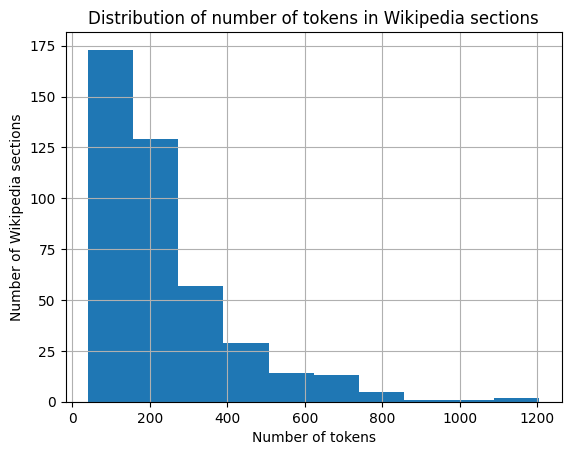

In [11]:
import pandas as pd
from matplotlib import pyplot as plt

df = pd.read_csv('prueba1.csv')
df[['tokens']].hist()
# add axis descriptions and title
plt.xlabel('Number of tokens')
plt.ylabel('Number of Wikipedia sections')
plt.title('Distribution of number of tokens in Wikipedia sections')
plt.show()

We can see that the majority of section are fairly short (less than 500 tokens).